### **Multi-class classification model using a custom Convolutional Neural Network in TensorFlow**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Mapping google drive to refer the dataset in the program

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/'Colab Notebooks'/CNN_assignment.zip

Here we are using a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively. We would need to check for class imbalances later and take the appropriate remedies.

In [4]:
!ls

 drive	      'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [5]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [6]:
# Define the paths of the train and test dataset
train_data_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data_dir = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
# Printing the count of images in each directory
img_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print("Total no of train images:\t", img_count_train)
img_count_test = len(list(test_data_dir.glob('*/*.jpg')))
print("Total no of test images:\t", img_count_test)

Total no of train images:	 2239
Total no of test images:	 118


### Load using keras.preprocessing

Load these images from disk using the image_dataset_from_directory utility.

### Create a dataset

Define parameters for the loader

In [8]:
batch_size = 32
img_height = 180
img_width = 180

We will follow 80:20 ratio, use 80% of the images for training, and 20% for validation.

In [9]:
## Preparing train dataset here
## using seed=123 for tf.keras.preprocessing.image_dataset_from_directory
## resizing images as requested in assignment to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Preapring validation dataset here
## Using seed=123 for tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List all the classes of skin cancer and save in a list.
# class names are in the class_names attribute.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

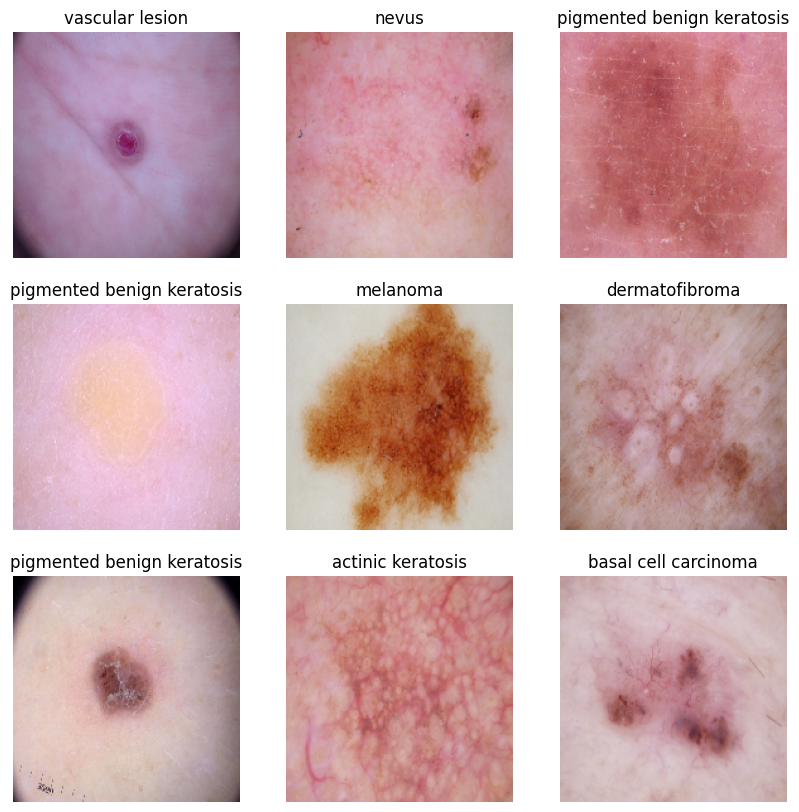

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. The `label_batch` is a tensor of the shape `(32,)`, related to labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded from the disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range and have to be standardized values in the `[0, 1]` range.

In [14]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compile the model
Chose the optimiser and loss function for model training

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 78ms/step - loss: 1.9989 - accuracy: 0.2746 - val_loss: 1.7442 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6170 - accuracy: 0.4297 - val_loss: 1.4616 - val_accuracy: 0.4989
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4300 - accuracy: 0.5106 - val_loss: 1.4718 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3652 - accuracy: 0.5073 - val_loss: 1.4939 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2608 - accuracy: 0.5396 - val_loss: 1.4587 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1682 - accuracy: 0.5848 - val_loss: 1.4036 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1464 - accuracy: 0.5971 - val_loss: 1.3561 - val_accuracy: 0.5347
Epoch 8/20
5

### Visualizing training results

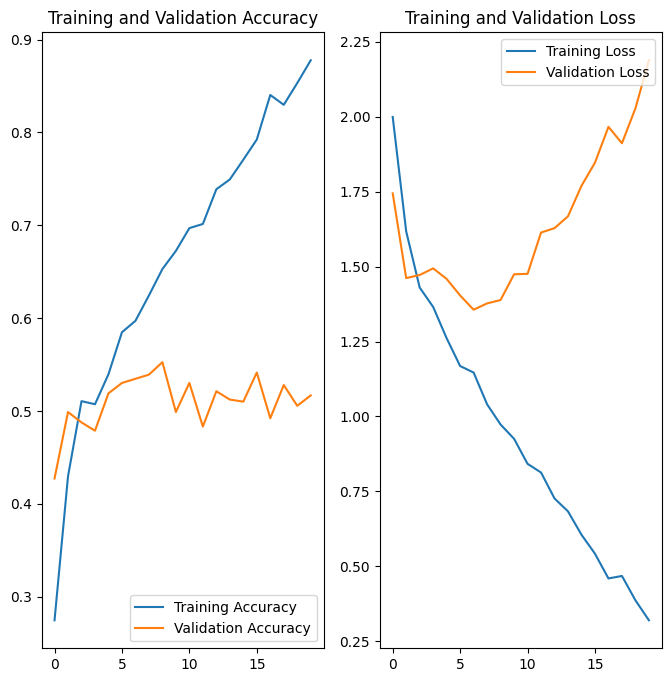

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit and looking for an evidence of model overfit or underfit

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stays between 50% to 60% in the training process. Also, the difference in accuracy between training and validation accuracy is big. It is an indication of overfitting.

Now that we have concluded for overfitting, Let us try to resolve it using data augmentation.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

###visualize augmentation strategy working for one instance of training image

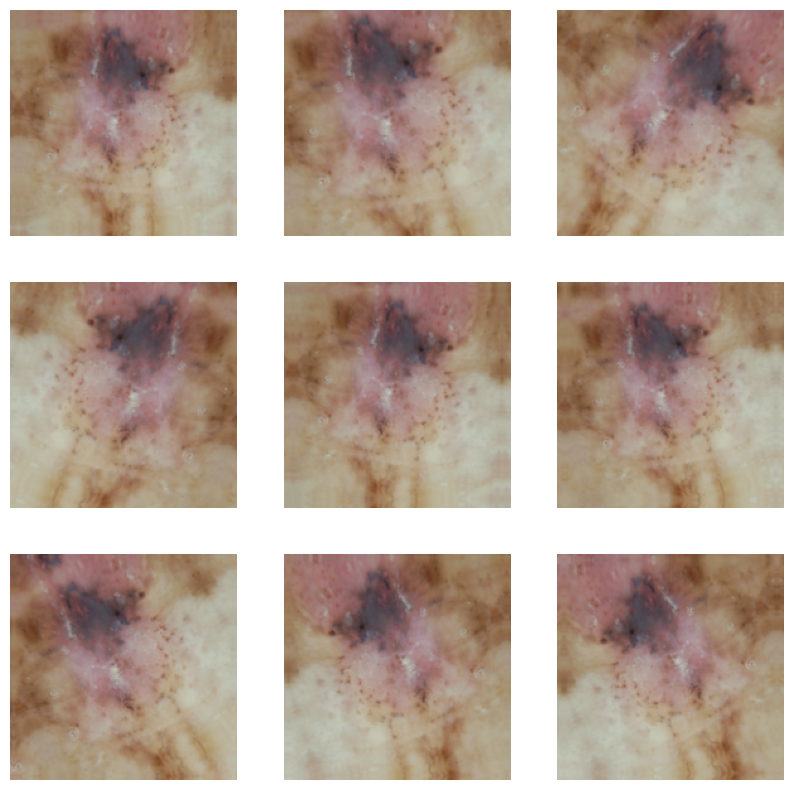

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create, compile and train the model


In [21]:

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model
Training model for 20 epochs

In [24]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 33ms/step - loss: 2.0270 - accuracy: 0.2584 - val_loss: 1.7828 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7129 - accuracy: 0.3917 - val_loss: 1.8232 - val_accuracy: 0.3423
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6358 - accuracy: 0.4135 - val_loss: 1.5820 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5561 - accuracy: 0.4330 - val_loss: 1.5452 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5042 - accuracy: 0.4749 - val_loss: 1.4544 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4590 - accuracy: 0.4855 - val_loss: 1.4917 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4001 - accuracy: 0.5056 - val_loss: 1.4689 - val_accuracy: 0.4966
Epoch 8/20
56

### Visualizing the results

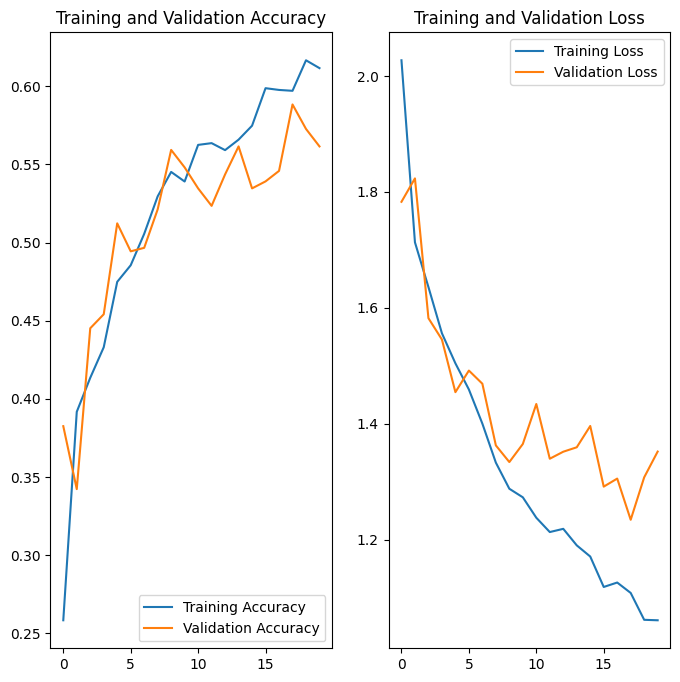

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, note the evidence of model overfit or underfit.

In the plots above, the training and validation accuracy is increasing over time. But validation accuracy is fluctuating in a wide range. Let us look for the evidence of class imbalances.

#### Find the distribution of classes in the training dataset.

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(train_data_dir, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_data_dir, '*', '*.jpg'))]
len(path_list)

2239

In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
1,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
3,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
4,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2235,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2236,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2237,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma


Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)
Class=5, n=462 (20.634%)
Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=8, n=139 (6.208%)
Class=7, n=181 (8.084%)


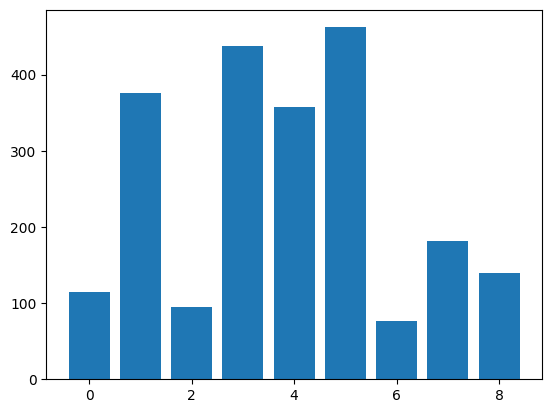

In [28]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Observations**
#### - Which class has the least number of samples? seborrheic keratosis class of skin cancer has the least number of samples in dataset.
#### - 'basal cell carcinoma', 'melanoma' , 'nevus' and 'pigmented benign keratosis' classes have the highest number of samples available dominating all other classes causing variation in the accurancy.

#### **Resolving the class imbalance**
#### Using python package `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure will be followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE878092B90>: 100%|██████████| 500/500 [00:15<00:00, 32.50 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE7D4C2A050>: 100%|██████████| 500/500 [00:15<00:00, 33.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE7D02C3F40>: 100%|██████████| 500/500 [00:17<00:00, 28.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7EE7D0C5C700>: 100%|██████████| 500/500 [01:20<00:00,  6.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7EE7D4C2A410>: 100%|██████████| 500/500 [01:17<00:00,  6.45 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE7D02E2800>: 100%|██████████| 500/500 [00:15<00:00, 31.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EE7D02F0A90>: 100%|██████████| 500/500 [00:36<00:00, 13.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE7D4C41F30>: 100%|██████████| 500/500 [00:16<00:00, 30.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE8687D7670>: 100%|██████████| 500/500 [00:15<00:00, 31.69 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets find the total count of augmented images.

In [31]:
img_count_train = len(list(train_data_dir.glob('*/output/*.jpg')))
print(img_count_train)

4500


### Find the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_24e9d61c-7485-49bc-9566-b7ca896dbefc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_4ba6643f-43c2-46fa-8986-80b872d80b6d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010993.jpg_8d03ab80-15d7-473b-85eb-60da9a669407.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_c2000161-b74d-426b-93e6-f57e71b6fb60.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_1beccd8e-d9cd-4cb3-8e12-524c2e0c4beb.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaborat

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [34]:
df_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(df_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-35-e82860307f5d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

We have added 500 images to all the classes to improve class balance.

#### **Training the model on the data created using Augmentor**

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [39]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating model
##### Using normalization

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile model (optimizer and loss function applied)

In [41]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Training model**
Using 30 epoches as suggested in assignment

In [42]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 65ms/step - loss: 1.8233 - accuracy: 0.2997 - val_loss: 1.5301 - val_accuracy: 0.4202
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 1.4337 - accuracy: 0.4683 - val_loss: 1.3052 - val_accuracy: 0.5249
Epoch 3/30
169/169 [==============================] - 5s 28ms/step - loss: 1.2200 - accuracy: 0.5529 - val_loss: 1.1587 - val_accuracy: 0.5664
Epoch 4/30
169/169 [==============================] - 5s 29ms/step - loss: 1.0350 - accuracy: 0.6092 - val_loss: 1.0639 - val_accuracy: 0.6125
Epoch 5/30
169/169 [==============================] - 5s 28ms/step - loss: 0.8622 - accuracy: 0.6830 - val_loss: 0.9616 - val_accuracy: 0.6511
Epoch 6/30
169/169 [==============================] - 5s 29ms/step - loss: 0.7226 - accuracy: 0.7409 - val_loss: 0.8601 - val_accuracy: 0.6823
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.5931 - accuracy: 0.7860 - val_loss: 0.8493 - val_accuracy: 0.724

#### Visualizing the model results

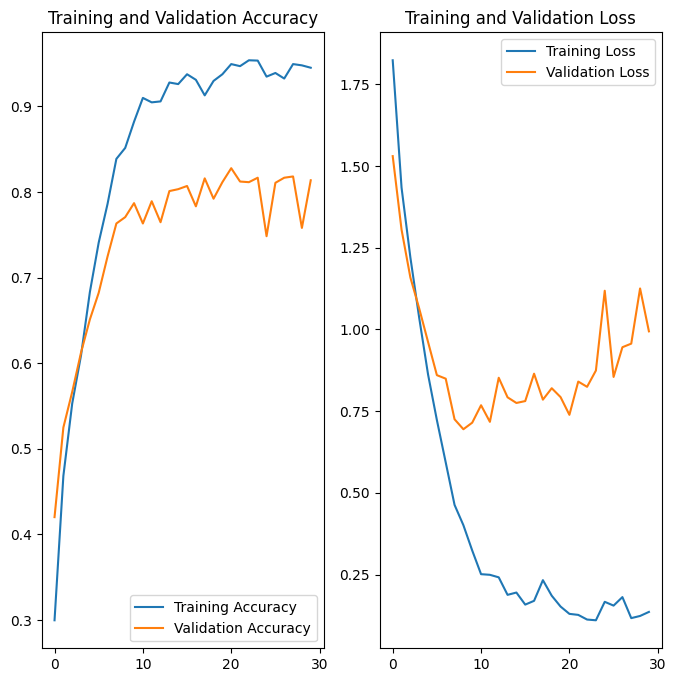

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing results.
Did we get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
Training accuracy has improved significantly from 60% or so to 90%. But most of the change is observed in Validation accuracy which has reached 80%.

Fluctuation in the curve has also reduced indicating that class imabalance reduction has helped in improving the matrices.